In [2]:
import pandas as pd

df = pd.read_csv('/home/mohammadseyfi/Desktop/deeplearning/HousePricePrediction/train.csv')

print("First 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values per Column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   200

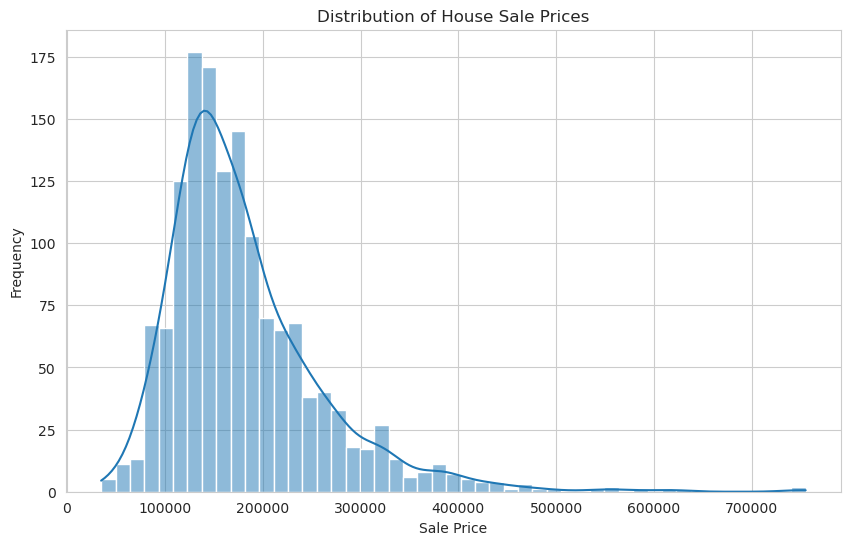

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Plot the distribution of SalePrice
plt.figure(figsize=(10,6))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of House Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Check again for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values before cleaning:")
print(missing.sort_values(ascending=False))
print("\nTotal columns with missing values:", len(missing))

Missing values before cleaning:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

Total columns with missing values: 19


In [5]:
# Make a copy of the original dataframe to avoid modifying it directly
df_clean = df.copy()

# Drop columns with more than 50% missing values (e.g., PoolQC, MiscFeature, Alley)
threshold = len(df_clean) * 0.5
df_clean = df_clean.dropna(axis=1, thresh=threshold)

# Fill remaining numerical missing values with median
numeric_cols = df_clean.select_dtypes(include=['number']).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Fill remaining categorical missing values with mode
categorical_cols = df_clean.select_dtypes(include=['object']).columns
df_clean[categorical_cols] = df_clean[categorical_cols].fillna(df_clean[categorical_cols].mode().iloc[0])

# Check again for missing values
missing_after = df_clean.isnull().sum()[df_clean.isnull().sum() > 0]
print("\nMissing values after cleaning:")
print(missing_after)


Missing values after cleaning:
Series([], dtype: int64)


In [6]:
# Separate out the target variable
X = df_clean.drop('SalePrice', axis=1)
y = df_clean['SalePrice']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Check final shape
print("\nFinal feature matrix shape:", X.shape)


Final feature matrix shape: (1460, 237)


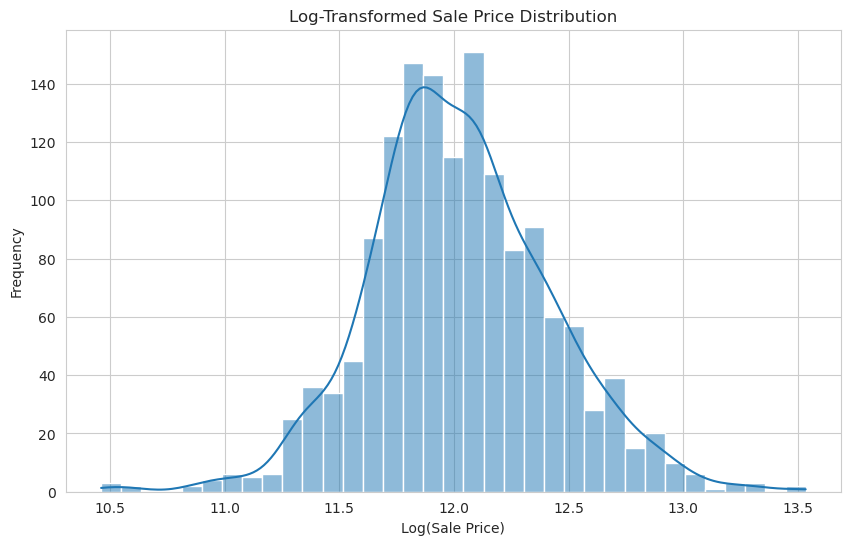

In [7]:
import numpy as np

# Apply log transformation to SalePrice (target variable)
y_log = np.log(y)

# Plot transformed distribution
plt.figure(figsize=(10,6))
sns.histplot(y_log, kde=True)
plt.title('Log-Transformed Sale Price Distribution')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1168, 237)
Test set shape: (292, 237)


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [10]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.1001
RMSE: 0.1479
R² Score: 0.8827


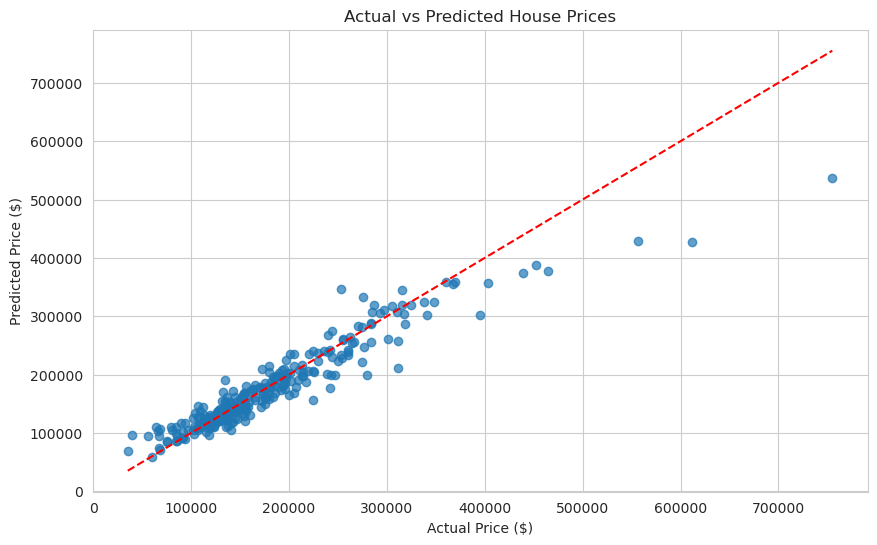

In [11]:
# Convert log prices back to original scale
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='red', linestyle='--')  # Line for perfect predictions
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True)
plt.show()

/tmp/ipykernel_21039/1884053334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


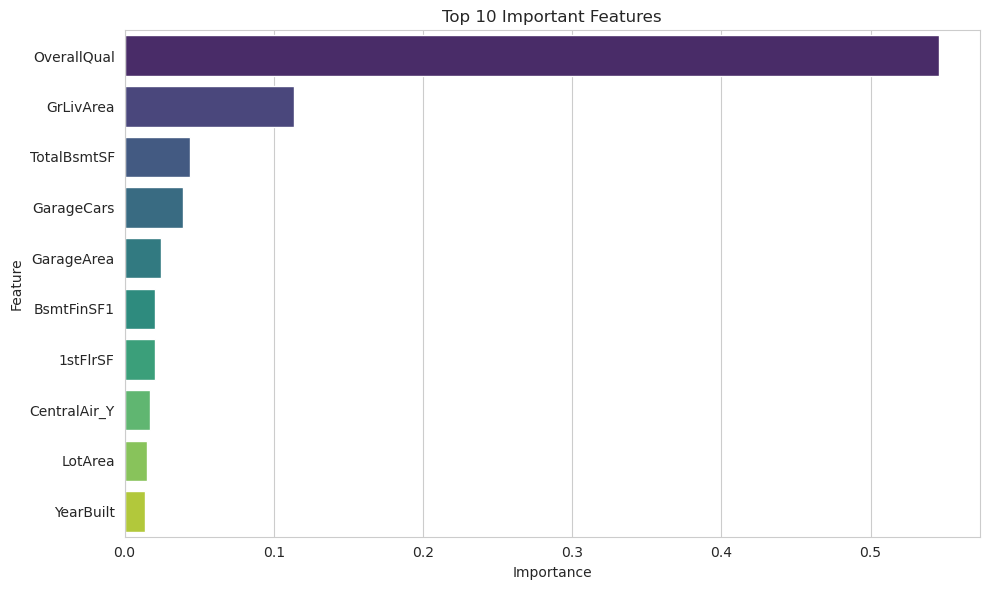

In [12]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feat_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

Hyperparameter Tuning with RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define hyperparameter distributions
param_dist = {
    'n_estimators': randint(100, 300),         # Number of trees
    'max_depth': [None, 10, 20, 30],           # Max depth of trees
    'min_samples_split': randint(2, 11),       # Min samples to split a node
    'min_samples_leaf': randint(1, 6),         # Min samples in a leaf
    'max_features': ['sqrt', 'log2'],          # Number of features considered per split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used
}

In [14]:
# Initialize the base model
base_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,               # Number of parameter combinations to try
    scoring='r2',
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,               # Use all available CPU cores
    random_state=42
)

# Fit on the training data
search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa21e25fd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa21e27ad0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa23387950>},
                   random_state=42, scoring='r2', verbose=1)

In [15]:
# Get the best model
best_rf = search.best_estimator_

# Make predictions with the best model
y_pred_best = best_rf.predict(X_test)

# Evaluate metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Parameters: {search.best_params_}")
print(f"MAE: {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R² Score: {r2_best:.4f}")

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 140}
MAE: 0.0993
RMSE: 0.1567
R² Score: 0.8683


XGBoost

In [16]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
# Initialize XGBoost Regressor with default hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # for regression
    random_state=42,
    n_estimators=100,
    early_stopping_rounds=10       # Optional: helps prevent overfitting
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Set to True if you want to see training logs
)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

In [18]:
# Convert predictions back from log scale
y_test_original = np.exp(y_test)
y_pred_original_xgb = np.exp(y_pred_xgb)

# Calculate metrics
mae_xgb = mean_absolute_error(y_test_original, y_pred_original_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred_original_xgb))
r2_xgb = r2_score(y_test_original, y_pred_original_xgb)

print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

MAE: 17717.52
RMSE: 27485.12
R² Score: 0.9015


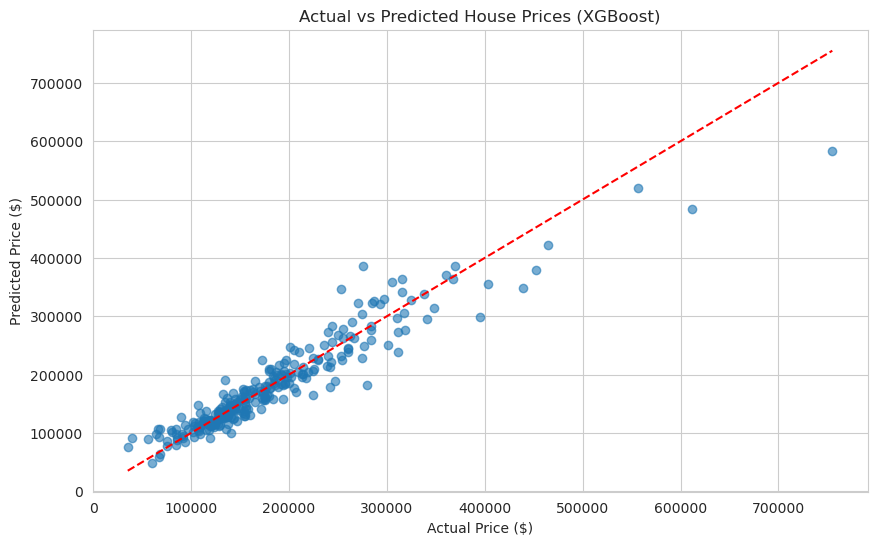

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_original, y_pred_original_xgb, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='red', linestyle='--')
plt.title('Actual vs Predicted House Prices (XGBoost)')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True)
plt.show()

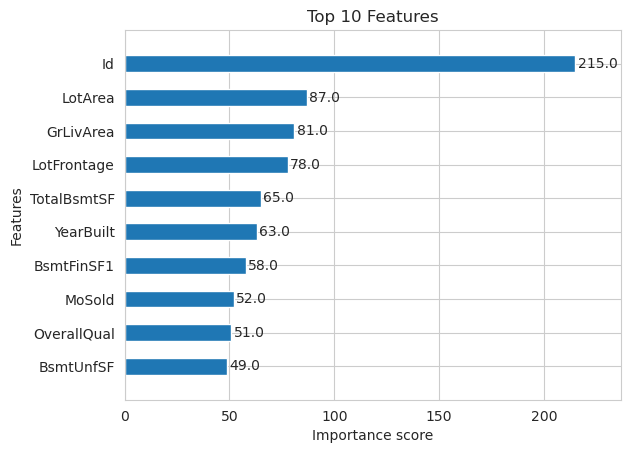

In [20]:
# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5, title='Top 10 Features')
plt.show()

In [ ]:
LightGBM

In [21]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
# Initialize the model with default parameters
lgb_model = LGBMRegressor(
    random_state=42,
    n_estimators=100
)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3391
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 153
[LightGBM] [Info] Start training from score 12.030652


In [23]:
# Convert predictions back from log scale
y_pred_original_lgb = np.exp(y_pred_lgb)

# Calculate metrics
mae_lgb = mean_absolute_error(y_test_original, y_pred_original_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test_original, y_pred_original_lgb))
r2_lgb = r2_score(y_test_original, y_pred_original_lgb)

print(f"MAE: {mae_lgb:.2f}")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")

MAE: 16770.68
RMSE: 29655.38
R² Score: 0.8853


Hyperparameter Tuning for LightGBM

In [24]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist_lgb = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 200),            # LightGBM uses num_leaves instead of max_depth
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(1, 20),       # Minimum number of samples per leaf
    'reg_alpha': uniform(0, 1),                # L1 regularization
    'reg_lambda': uniform(0, 1)                # L2 regularization
}

# Initialize base model
base_lgb = LGBMRegressor(random_state=42)

# Setup RandomizedSearchCV
search_lgb = RandomizedSearchCV(
    estimator=base_lgb,
    param_distributions=param_dist_lgb,
    n_iter=30,              # Try 30 combinations
    scoring='r2',
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

# Fit on training data
search_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 179
[LightGBM] [Info] Start training from score 12.020792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa21383c80>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa21383fe0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_d...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa21383ec0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa21383a70>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa213835c0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa21383c20>},
                   random_state=42, scoring='r2', verbose=1)

In [25]:
# Get best model
best_lgb = search_lgb.best_estimator_

# Predict with best model
y_pred_best_lgb = best_lgb.predict(X_test)

# Convert predictions back from log scale
y_pred_best_original_lgb = np.exp(y_pred_best_lgb)

# Evaluate metrics
mae_best_lgb = mean_absolute_error(y_test_original, y_pred_best_original_lgb)
rmse_best_lgb = np.sqrt(mean_squared_error(y_test_original, y_pred_best_original_lgb))
r2_best_lgb = r2_score(y_test_original, y_pred_best_original_lgb)

print(f"Best Parameters: {search_lgb.best_params_}")
print(f"MAE: {mae_best_lgb:.2f}")
print(f"RMSE: {rmse_best_lgb:.2f}")
print(f"R² Score: {r2_best_lgb:.4f}")

Best Parameters: {'colsample_bytree': 0.6132202931602193, 'learning_rate': 0.11352137440800489, 'max_depth': 3, 'min_child_samples': 19, 'n_estimators': 225, 'num_leaves': 149, 'reg_alpha': 0.5309345833171364, 'reg_lambda': 0.44778316457309164, 'subsample': 0.8211572356285312}
MAE: 16630.55
RMSE: 29561.70
R² Score: 0.8861


Hyperparameter Tuning for XGBoost

In [26]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),        # Fraction of rows used per tree
    'colsample_bytree': uniform(0.6, 0.4), # Fraction of columns used per tree
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 5)                 # Minimum loss reduction to make partition
}

# Initialize base model
base_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Setup RandomizedSearchCV
search_xgb = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,              # Try 30 combinations
    scoring='r2',
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

# Fit on training data
search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa213c4740>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa21370620>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ffa213c4cb0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffa213c4590>},
                   random_state=42, scoring='r2', verbose=1)

In [27]:
# Get best model
best_xgb = search_xgb.best_estimator_

# Predict with best model
y_pred_best_xgb = best_xgb.predict(X_test)

# Convert predictions back from log scale
y_pred_best_original = np.exp(y_pred_best_xgb)

# Evaluate metrics
mae_best_xgb = mean_absolute_error(y_test_original, y_pred_best_original)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred_best_original))
r2_best_xgb = r2_score(y_test_original, y_pred_best_original)

print(f"Best Parameters: {search_xgb.best_params_}")
print(f"MAE: {mae_best_xgb:.2f}")
print(f"RMSE: {rmse_best_xgb:.2f}")
print(f"R² Score: {r2_best_xgb:.4f}")

Best Parameters: {'colsample_bytree': 0.7173952698872152, 'gamma': 0.07039911357542228, 'learning_rate': 0.06965272122664154, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 132, 'subsample': 0.8423839899124046}
MAE: 16344.49
RMSE: 26575.26
R² Score: 0.9079
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [29]:
!pip install tensorflow_decision_forests

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow_decision_forests from https://files.pythonhosted.org/packages/76/ff/359b34530d03343d294ee3e27b8155f627b8571a3558ba396b1955d83ad7/tensorflow_decision_forests-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow_decision_forests-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Obtaining dependency information for tensorflow==2.19.0 from https://files.pythonhosted.org/packages/01/12/a8ad8322a7cb2818e658a073feb2aa541d0e6a32b8e5ac838d46e0882687/tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Obtaining dependency information for wurlitzer from https://files.pythonhosted.org/packages/9a/24/93ce54550a9dd3fd996ed477f00221f215bf6da3580397f